In [ ]:
# https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class5_class_reg.ipynb

In [1]:
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

c:\users\fr23505\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

In [3]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [4]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

In [11]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [12]:
preprocess = False

In [13]:
filename_read = r"c:\Users\fr23505\Documents\machine\git\data\mpg.csv"
df = pd.read_csv(filename_read,na_values=['NA','?'])

In [14]:
# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')

In [16]:
# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

In [17]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

In [18]:
model = Sequential()
model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

In [19]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

In [ ]:
filename_write= r"C:\Users\fr23505\Documents\machine\git\data\best_weights.hdf5"
checkpointer = ModelCheckpoint(filepath=filename_write, verbose=1, save_best_only=True) # save best model

In [20]:
#model.fit(x_train,y_train,verbose=0,epochs=1000)
model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=0,epochs=2000)
#model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)

In [21]:
#model.load_weights(filename_write)
model.load_weights('best_weights.hdf5') # load weights from best model

OSError: Unable to open file (unable to open file: name = 'best_weights.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [22]:
# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 2.984631061553955


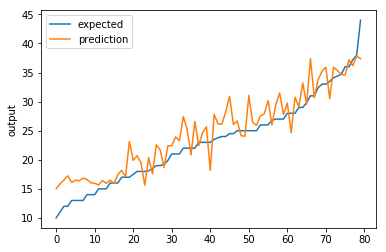

In [23]:
# Plot the chart
chart_regression(pred.flatten(),y_test)

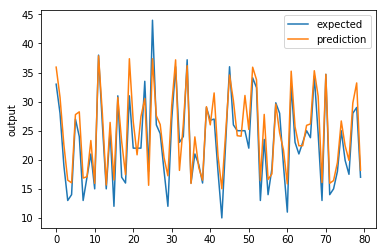

In [24]:
chart_regression(pred.flatten(),y_test,sort=False)